# ANDES and OpenDSS Tutorial

| Information | Details |
|----------|---------|
| Lead Author | Xin Fang |
| Learning Objectives | • Understand transmission system dynamic simulation<br>• Learn distribution system steady-state analysis<br>• Apply ANDES for generator contingency analysis<br>• Use OpenDSS for distribution feeder simulation<br>• Analyze system response under disturbances |
| Prerequisites | Python basics, power flow fundamentals, NumPy/Matplotlib |
| Estimated Time | 90 minutes |
| Topics | Dynamic simulation, distribution analysis, ANDES, OpenDSS, contingency analysis, DER integration |

## Introduction

Power system simulation spans multiple scales and timescales, from transmission-level dynamics occurring in seconds to distribution-level steady-state conditions. This tutorial introduces two essential open-source tools that address these complementary aspects of power system analysis.

ANDES focuses on transmission system dynamic simulation, capturing the time-dependent behavior of generators, their controls, and system-wide stability following disturbances. Unlike steady-state power flow, dynamic simulation reveals how rotor angles, frequencies, and voltages evolve over time after events like faults or generator trips. This capability is essential for ensuring system stability under N-1 contingencies that system operators must routinely evaluate.

OpenDSS complements this with detailed distribution system analysis, modeling the radial networks that deliver power to end consumers. Distribution systems operate at lower voltages and present unique challenges including unbalanced phases, distributed energy resources (DERs), and time-varying loads. Understanding both transmission dynamics and distribution behavior provides a complete picture of modern power system operation.

This tutorial demonstrates practical applications of both tools through hands-on examples. We'll first explore transmission system dynamics using ANDES to simulate a generator trip, then examine distribution system behavior with OpenDSS including DER integration. The focus remains on understanding fundamental concepts through code rather than extensive theory.

## Transmission System Dynamic Simulation with ANDES

### Understanding Dynamic Simulation

Dynamic simulation captures the evolution of power system variables over time by solving differential-algebraic equations (DAEs). When a generator trips or a fault occurs, the system doesn't instantly reach a new equilibrium. Instead, generator rotors accelerate or decelerate, automatic voltage regulators respond, and governors adjust mechanical power input. These dynamics unfold over seconds to minutes and determine whether the system remains stable or cascades toward blackout.

The process begins with a steady-state power flow solution representing normal operation. From this initial condition, we introduce a disturbance and integrate the system equations forward in time. The resulting trajectories of rotor angles, frequencies, and voltages reveal system stability. Key metrics include the rate of change of frequency (RoCoF), frequency nadir during transients, and the final settling frequency after disturbances.

ANDES implements industry-standard dynamic models for generators, exciters, governors, and other components. It efficiently solves the resulting DAE systems while providing flexibility for research applications. Let's demonstrate these concepts through a practical example.

### Generator Trip Example

We'll simulate a generator trip in the IEEE 14-bus test system to observe frequency and voltage responses. This example represents a common contingency that system operators must evaluate to ensure adequate reserves and stability margins.

In [1]:
# Install ANDES if not already available
!pip install andes --quiet

In [2]:
import andes
import matplotlib.pyplot as plt
import numpy as np

First, we load the IEEE 14-bus system and configure it for dynamic simulation. The test case includes detailed generator models, automatic voltage regulators, and governors necessary for capturing realistic dynamic behavior.

In [3]:
# Load IEEE 14-bus system with full dynamic models
ieee14 = andes.get_case("ieee14/ieee14_full.xlsx")
ss = andes.load(ieee14, setup=False, no_output=True)

# Add generator trip event at t=2.0 seconds
ss.add("Toggle", dict(model='SynGen', dev="GENROU_3", t=2.0))

# Complete system setup after adding contingency
ss.setup()

# Configure loads as constant power for clearer frequency response
ss.PQ.config.p2p = 1
ss.PQ.config.q2q = 1
ss.PQ.config.p2z = 0
ss.PQ.config.q2z = 0

# Solve initial power flow
ss.PFlow.run()

True

Now we run the time-domain simulation for 20 seconds, allowing sufficient time to observe both the transient response and the approach to a new steady state. The simulation captures the system's immediate response to losing generation capacity and the subsequent governor actions to restore frequency.

In [5]:
# Configure and run time-domain simulation
ss.TDS.config.tf = 20  # Total simulation time
ss.TDS.config.no_tqdm = True # disable progress bar

# Disable automatic stability checks for this example
ss.TDS.config.criteria = 0  

ss.TDS.run()

True

### Analyzing System Response

The simulation results reveal how the system responds to losing Generator 3. We'll examine both frequency and voltage trajectories to understand the dynamic behavior.

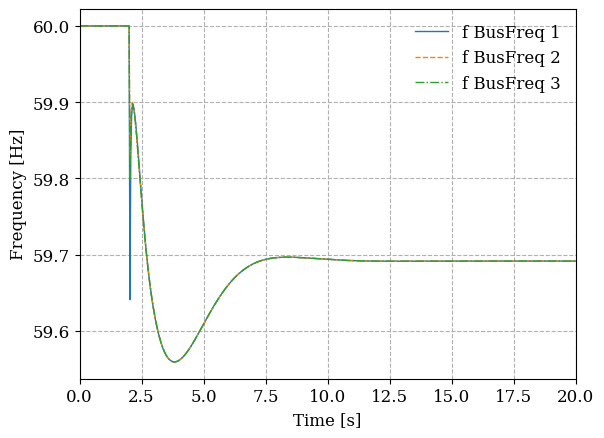

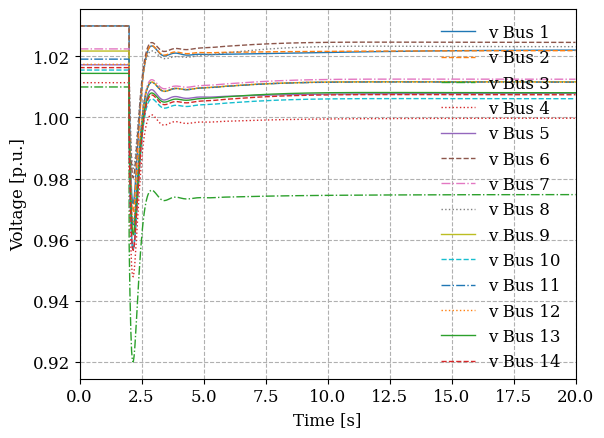

(<Figure size 640x480 with 1 Axes>,
 <Axes: xlabel='Time [s]', ylabel='Voltage [p.u.]'>)

In [6]:
%matplotlib inline

# Plot frequency response at monitored buses
ss.TDS.plt.plot(ss.BusFreq.f,
                ytimes=60,  # Convert to Hz
                latex=False,
                grid=True,
                legend=True,
                ylabel='Frequency [Hz]')

# Plot voltage magnitude response
ss.TDS.plt.plot(ss.Bus.v,
                latex=False,
                grid=True,
                legend=True,
                ylabel='Voltage [p.u.]')

The frequency response shows the characteristic drop following generation loss. The initial rate of change depends on system inertia, while the nadir and settling frequency depend on governor response and available reserves. The voltage response indicates local impacts near the tripped generator and system-wide adjustments through automatic voltage regulation.

These metrics are critical for system planning and operation. The frequency nadir must remain above underfrequency load shedding thresholds, while the settling frequency indicates whether remaining generation can meet demand. System operators use such simulations to verify adequate reserves and response capability.

## Distribution System Analysis with OpenDSS

### Distribution System Characteristics

Distribution systems differ fundamentally from transmission networks in both structure and operation. They typically operate radially, delivering power from substations to end users through feeders at medium and low voltages. These networks face unique challenges including voltage regulation along feeders, phase imbalances, and increasingly, the integration of distributed energy resources.

OpenDSS specializes in distribution system simulation, providing detailed models for transformers, lines, loads, and DERs. It handles unbalanced three-phase networks naturally and supports various analysis modes from snapshot power flow to time-series simulations. The tool's strength lies in evaluating hosting capacity, protection coordination, and voltage regulation with high DER penetration.

We'll demonstrate OpenDSS capabilities through a simplified feeder with solar PV integration, showing how time-varying loads and generation affect system operation.

### Building a Distribution Feeder with DERs

In [7]:
# Install OpenDSSDirect.py interface
!pip install OpenDSSDirect.py --quiet

In [14]:
import opendssdirect as dss
import pandas as pd

We'll create a simple distribution feeder with multiple loads and solar PV systems. This configuration represents a typical suburban feeder experiencing increasing solar adoption.

In [15]:
def create_der_enabled_distribution_system():
    """
    Create a distribution feeder with integrated solar PV.
    """
    # Clear any existing circuit
    dss.Command('Clear')
    
    # Define the distribution system
    commands = [
        "New Circuit.DER_Test basekv=24.9 phases=3",
        
        # Feeder segments
        "New Line.L1 bus1=sourcebus bus2=800 length=2 units=km",
        "New Line.L2 bus1=800 bus2=802 length=1 units=km",
        "New Line.L3 bus1=800 bus2=806 length=1.5 units=km",
        "New Line.L4 bus1=802 bus2=808 length=0.5 units=km",
        
        # Customer loads
        "New Load.L1 bus1=802 kV=24.9 kW=500 kvar=100 model=1",
        "New Load.L2 bus1=806 kV=24.9 kW=800 kvar=200 model=1",
        "New Load.L3 bus1=808 kV=24.9 kW=300 kvar=80 model=1",
        
        # Rooftop solar installations
        "New Generator.PV1 bus1=802 kV=24.9 kW=200 pf=1.0 model=7",
        "New Generator.PV2 bus1=806 kV=24.9 kW=200 pf=1.0 model=7",
        
        # System configuration
        "Set Voltagebases=[24.9]",
        "Calcvoltagebases"
    ]
    
    for cmd in commands:
        dss.Command(cmd)
    
    # Set solution mode
    dss.Command("Set Mode=Snap")
    dss.Command("Set ControlMode=Static")
    
    return commands

# Create the system and solve initial conditions
print("Creating distribution system with DERs...")
create_der_enabled_distribution_system()
dss.Command("Solve")
print(f"Net feeder load: {-dss.Circuit.TotalPower()[0]:.1f} kW")

Creating distribution system with DERs...
Net feeder load: 1200.4 kW


### Time-Series Analysis with Load Variations

Distribution systems experience continuous variation in both load and DER output. We'll simulate these variations to observe their impact on voltage profiles along the feeder. This analysis helps identify potential voltage violations and the need for regulation equipment.

In [ ]:
consistent_random_object = np.random.RandomState(981)
load_profile_random = consistent_random_object.normal(1,0.025, 15) 

T = len(load_profile_random)
# Get node order once 
node_names = dss.Circuit.AllNodeNames()
N = len(node_names)
# --- store original kW before loop ---
original_loads = {}
load_names = dss.Loads.AllNames()

for name in load_names:
    dss.Loads.Name(name)
    original_loads[name] = dss.Loads.kW()  # store original value
    
# Storage for per-node per-unit voltages over time
Vpu = np.zeros((T, N))

# Main loop for 15s simulation
for t in range(T):
    scale = load_profile_random[t]

    # Apply scaling to original loads
    for name in load_names:
        dss.Loads.Name(name)
        dss.Loads.kW(original_loads[name] * scale)

    dss.Solution.Solve()

    # store per-node voltage in per unit
    Vpu[t, :] = dss.Circuit.AllBusMagPu()

# Create DataFrame for analysis/plotting
Vpu_df = pd.DataFrame(Vpu, columns=node_names)

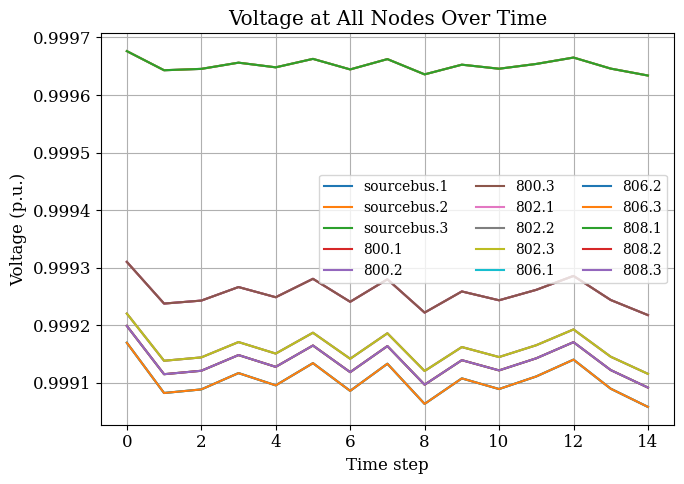

In [21]:
# Visualize the voltages

plt.figure(figsize=(7, 5))

# Plot all node voltages
for col in Vpu_df.columns:
    plt.plot(Vpu_df.index, Vpu_df[col], label=col)

plt.xlabel("Time step")
plt.ylabel("Voltage (p.u.)")
plt.title("Voltage at All Nodes Over Time")
plt.grid(True)
plt.legend(loc="best", fontsize="small", ncol=3)  
plt.tight_layout()
plt.show()

### DER Output Variations

Solar generation varies with cloud cover and time of day, creating additional challenges for voltage regulation. We'll simulate PV output variations to understand their impact on the distribution system.

In [22]:
# Get the random profile with 5% std for DER
DER_profile_random = consistent_random_object.normal(1, 0.05, 15) 
# Get original PV ratings (kW) once
base_pv_kw = {}
for pv_name in ["PV1", "PV2"]:
    dss.Generators.Name(pv_name)
    base_pv_kw[pv_name] = dss.Generators.kW()

# Get node names once
node_names = dss.Circuit.AllNodeNames()
N = len(node_names)

# Store 
pv1_kw_list = []
pv2_kw_list = []
Vpu_all_steps = np.zeros((len(DER_profile_random), N))

# Loop over 15 steps
for t, scale in enumerate(DER_profile_random):
    
    # Scale both PVs from their original rating
    for pv_name in ["PV1", "PV2"]:
        dss.Generators.Name(pv_name)
        dss.Generators.kW(base_pv_kw[pv_name] * scale)

    # Solve power flow
    dss.Solution.Solve()

    # Store PV outputs
    dss.Generators.Name("PV1")
    pv1_kw_list.append(dss.Generators.kW())
    dss.Generators.Name("PV2")
    pv2_kw_list.append(dss.Generators.kW())

    # Store voltage magnitudes (p.u.)
    Vpu_all_steps[t, :] = dss.Circuit.AllBusMagPu()

# Create DataFrames
df_pv = pd.DataFrame({"PV1_kW": pv1_kw_list, "PV2_kW": pv2_kw_list})
df_vpu = pd.DataFrame(Vpu_all_steps, columns=node_names)

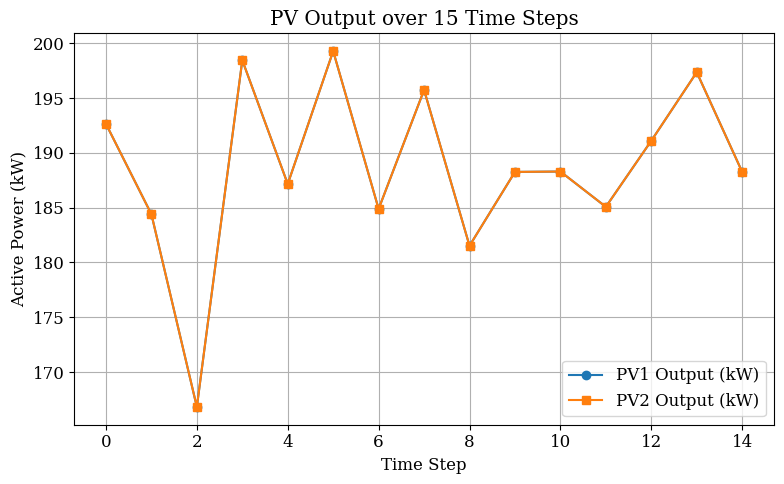

In [25]:
# Plot PV active power outputs 

plt.figure(figsize=(8, 5))
plt.plot(df_pv.index, df_pv["PV1_kW"], marker='o', label="PV1 Output (kW)")
plt.plot(df_pv.index, df_pv["PV2_kW"], marker='s', label="PV2 Output (kW)")
plt.xlabel("Time Step")
plt.ylabel("Active Power (kW)")
plt.title("PV Output over 15 Time Steps")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

The results demonstrate how DER output variations influence voltage profiles along the feeder. Higher solar generation tends to raise local voltages, potentially causing overvoltage conditions during light load periods. This reverse power flow challenge requires careful coordination of voltage regulation devices and potentially smart inverter controls to maintain power quality.

Distribution system operators use such analyses to determine hosting capacity, the maximum DER that can be accommodated without violating operational constraints. The simulations also inform interconnection studies and grid modernization investments.

## Summary

This tutorial demonstrated fundamental power system simulation capabilities using ANDES for transmission dynamics and OpenDSS for distribution analysis. ANDES revealed how generator trips affect system-wide frequency and voltage stability over seconds to minutes, while OpenDSS showed the localized impacts of load and DER variations on distribution feeders.

Together, these tools provide comprehensive simulation capabilities for modern power systems facing increasing renewable integration and evolving operational challenges. The open-source nature of both tools enables researchers and engineers to explore advanced scenarios and develop new solutions for grid reliability and resilience.

The next steps could include exploring co-simulation approaches that couple transmission and distribution models, implementing advanced controls, or analyzing specific scenarios relevant to your research or operational needs.

## References

1. ANDES Documentation: https://docs.andes.app/
2. ANDES GitHub Repository: https://github.com/CURENT/andes
3. OpenDSS Documentation: https://opendss.epri.com/IntroductiontoOpenDSS.html
4. OpenDSSDirect.py: https://dss-extensions.org/OpenDSSDirect.py/notebooks/Installation.html